## Homework

> Note: sometimes your answer doesn't match one of 
> the options exactly. That's fine. 
> Select the option that's closest to your solution.


In this homework, we will use the lead scoring dataset Bank Marketing dataset. Download it from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv).


In this dataset our desired target for classification task will be `converted` variable - has the client signed up to the platform or not. 

### Data preparation

* Check if the missing values are presented in the features.
* If there are missing values:
    * For caterogiral features, replace them with 'NA'
    * For numerical features, replace with with 0.0 


Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

In [49]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.model_selection import KFold

In [2]:
# !wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv

In [3]:
df_origin = pd.read_csv("course_lead_scoring.csv")

In [4]:
df_origin.isna().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [5]:
df_origin.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [6]:
def prepare_data(df):
    df_result = df.copy()
    df_result["annual_income"] = df_result["annual_income"].fillna(0)
    df_result["lead_source"] = df_result["lead_source"].fillna("NA")
    df_result["industry"] = df_result["industry"].fillna("NA")
    df_result["employment_status"] = df_result["employment_status"].fillna("NA")
    df_result["location"] = df_result["location"].fillna("NA")

    return df_result

In [7]:
df = prepare_data(df_origin)

In [8]:
df.isna().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [9]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NA,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NA,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [10]:
random_state = 1

In [11]:
target_column = "converted"
categorical_columns = ["lead_source", "industry", "employment_status", "location"]
numerical_columns = ["interaction_count", "lead_score", "number_of_courses_viewed", "annual_income"]

In [12]:
from pandas import DataFrame

def split_features_and_target(df_train: DataFrame, df_validation, df_test, target_column="converted"):
    y_train = df_train[target_column].copy().values
    y_validation = df_validation[target_column].copy().values
    y_test = df_test[target_column].copy().values

    df_train = df_train.drop([target_column], axis=1).copy()
    df_validation = df_validation.drop([target_column], axis=1).copy()
    df_test = df_test.drop([target_column], axis=1).copy()

    return df_train, y_train, df_validation, y_validation, df_test, y_test

In [13]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=random_state)

In [14]:
df_train, df_validation = train_test_split(df_full_train, test_size=0.25, random_state=random_state)

In [15]:
df_train, y_train, df_validation, y_validation, df_test, y_test = split_features_and_target(df_train, df_validation, df_test)

In [16]:
df_train.isna().sum(), df_validation.isna().sum(), df_test.isna().sum()

(lead_source                 0
 industry                    0
 number_of_courses_viewed    0
 annual_income               0
 employment_status           0
 location                    0
 interaction_count           0
 lead_score                  0
 dtype: int64,
 lead_source                 0
 industry                    0
 number_of_courses_viewed    0
 annual_income               0
 employment_status           0
 location                    0
 interaction_count           0
 lead_score                  0
 dtype: int64,
 lead_source                 0
 industry                    0
 number_of_courses_viewed    0
 annual_income               0
 employment_status           0
 location                    0
 interaction_count           0
 lead_score                  0
 dtype: int64)

In [17]:
def create_dictionaries(df_train, df_validation, columns):
    dict_train = df_train[columns].to_dict(orient="records")
    dict_validation = df_validation[columns].to_dict(orient="records")

    return dict_train, dict_validation

In [18]:
from sklearn.feature_extraction import DictVectorizer


def create_vectorizer_and_learn_categories(dict_train) -> DictVectorizer:
    dv = DictVectorizer(sparse=False)
    dv.fit(dict_train)

    return dv

In [19]:
def create_model_and_train(dict_train, y, dv: DictVectorizer) -> LogisticRegression:
    X = dv.transform(dict_train)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=random_state)
    model.fit(X, y)

    return model

In [20]:
def get_accuracy(X_validation, y_validation, model, threshold=0.5):
    y_pred = model.predict_proba(X_validation)[:,1]

    converted_validation_decision = (y_pred >= threshold)
    converted_validation_decision

    accuracy = (converted_validation_decision.astype(int) == y_validation).mean()

    return accuracy

### Accuracy and Dummy Model
Why do we use `0.5` as a threshold? can we find a better value?

In [21]:
thresholds = np.linspace(0, 1, 21)
thresholds

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [22]:
columns_accuracy = categorical_columns + numerical_columns
threshold_accuracy_collection = {}

dict_train, dict_validation = create_dictionaries(df_train, df_validation, columns_accuracy)
vectorizer_original_accuracy = create_vectorizer_and_learn_categories(dict_train)
model_original_accuracy = create_model_and_train(dict_train, y_train, vectorizer_original_accuracy)

X_validation = vectorizer_original_accuracy.transform(dict_validation)

for threshold in thresholds:
    accuracy = get_accuracy(X_validation, y_validation, model_original_accuracy, threshold)
    print(f"Accuracy for the threshold {threshold}: {accuracy}")
    threshold_accuracy_collection[threshold] = accuracy

Accuracy for the threshold 0.0: 0.5836177474402731
Accuracy for the threshold 0.05: 0.5836177474402731
Accuracy for the threshold 0.1: 0.5836177474402731
Accuracy for the threshold 0.15000000000000002: 0.5836177474402731
Accuracy for the threshold 0.2: 0.5836177474402731
Accuracy for the threshold 0.25: 0.5836177474402731
Accuracy for the threshold 0.30000000000000004: 0.5938566552901023
Accuracy for the threshold 0.35000000000000003: 0.6006825938566553
Accuracy for the threshold 0.4: 0.6416382252559727
Accuracy for the threshold 0.45: 0.6791808873720137
Accuracy for the threshold 0.5: 0.6996587030716723
Accuracy for the threshold 0.55: 0.7474402730375427
Accuracy for the threshold 0.6000000000000001: 0.7474402730375427
Accuracy for the threshold 0.65: 0.7337883959044369
Accuracy for the threshold 0.7000000000000001: 0.6928327645051194
Accuracy for the threshold 0.75: 0.6552901023890785
Accuracy for the threshold 0.8: 0.6143344709897611
Accuracy for the threshold 0.8500000000000001: 0.

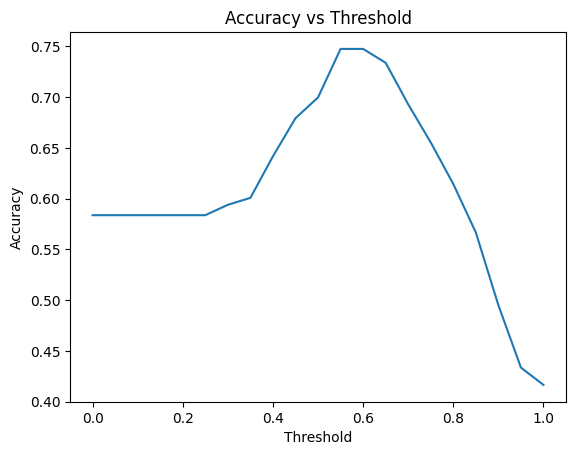

In [23]:
plt.plot(list(threshold_accuracy_collection.keys()), list(threshold_accuracy_collection.values()))
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Threshold')
plt.show()

Accuracy makes sense on the balance datasets.For instance, when the target value is close to 50%:

In [24]:
y_train.mean()

np.float64(0.6210045662100456)

With 62% of customers converted, accuracy becomes a misleading evaluation metric because a naive model could achieve high accuracy by simply always predicting the majority class, without learning the underlying patterns that distinguish converted from non-converted customers.

### Question 1: ROC AUC feature importance (Receiver Operating Characteristic Area Under the Curve)

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['balance']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `lead_score`
- `number_of_courses_viewed`
- `interaction_count`
- `annual_income`

In [25]:
for column in numerical_columns:
    score = roc_auc_score(y_train, df_train[column])

    if (score < 0.5):
        score = roc_auc_score(y_train, -df_train[column])

    print(f"The column name: {column}, score: {score}")

The column name: interaction_count, score: 0.738270176293409
The column name: lead_score, score: 0.6144993577250176
The column name: number_of_courses_viewed, score: 0.7635680590007088
The column name: annual_income, score: 0.5519578313253012


### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.32
- 0.52
- 0.72
- 0.92


In [26]:
columns_accuracy = categorical_columns + numerical_columns

dict_train, dict_validation = create_dictionaries(df_train, df_validation, columns_accuracy)
vectorizer = create_vectorizer_and_learn_categories(dict_train)

X_train = vectorizer.transform(dict_train)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

X_validation = vectorizer.transform(dict_validation)
y_pred = model.predict_proba(X_validation)[:, 1]

fpr, tpr, threshold = roc_curve(y_validation, y_pred)
score = round(auc(fpr, tpr), 2)
score

0.82

The answer without using the `round` method is close to 0.72

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.145
* 0.345
* 0.545
* 0.745

In [27]:
thresholds = np.linspace(0, 1, 101)
thresholds

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [28]:
def calculate_tp_fp_tn_fn(y_pred, y):
    tp = np.sum((y == 1) & (y_pred == 1))
    tn = np.sum((y == 0) & (y_pred == 0))
    fp = np.sum((y == 0) & (y_pred == 1))
    fn = np.sum((y == 1) & (y_pred == 0))

    return float(tp), float(fp), float(tn), float(fn)

In [29]:
columns_accuracy = categorical_columns + numerical_columns
threshold_collection = {}

dict_train, dict_validation = create_dictionaries(df_train, df_validation, columns_accuracy)
vectorizer = create_vectorizer_and_learn_categories(dict_train)
model = create_model_and_train(dict_train, y_train, vectorizer)

X_validation = vectorizer.transform(dict_validation)
y_pred_probability = model.predict_proba(X_validation)[:,1]

for threshold in thresholds:
    try:
        y_pred = (y_pred_probability >= threshold)
        tp, fp, tn, fn = calculate_tp_fp_tn_fn(y_pred, y_validation)

        if (tp + fp) > 0:
            precision = tp / (tp + fp)
        else:
            precision = float("nan")

        if tp + fn > 0:
            recall = tp / (tp + fn)
        else:
            recall = float("nan")

        threshold_collection[threshold] = (precision, recall)
    except Exception as ex:
        print(threshold, ex)

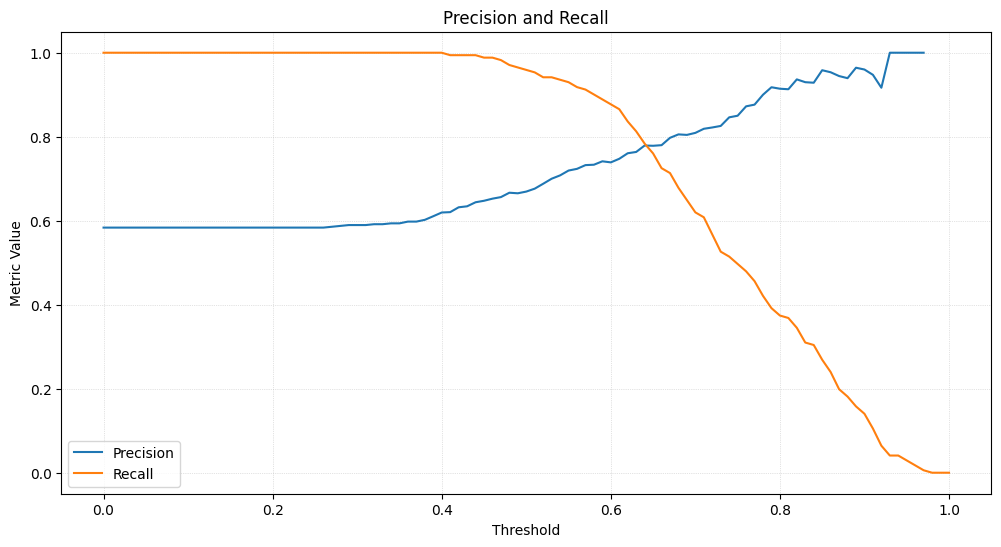

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(list(threshold_collection.keys()),
         [v[0] for v in threshold_collection.values()],
    label="Precision")

plt.plot(list(threshold_collection.keys()),
         [v[1] for v in threshold_collection.values()],
         label="Recall")

plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Precision and Recall')
plt.legend()

plt.grid(True, which='both', linestyle=':', linewidth=0.5, alpha=0.7)

plt.show()

The most closest value is `0.545`

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.14
- 0.34
- 0.54
- 0.74

In [31]:
columns_accuracy = categorical_columns + numerical_columns
threshold_collection = {}

dict_train, dict_validation = create_dictionaries(df_train, df_validation, columns_accuracy)
vectorizer = create_vectorizer_and_learn_categories(dict_train)
model = create_model_and_train(dict_train, y_train, vectorizer)

X_validation = vectorizer.transform(dict_validation)
y_pred_probability = model.predict_proba(X_validation)[:,1]

for threshold in thresholds:
    try:
        y_pred = (y_pred_probability >= threshold)
        tp, fp, tn, fn = calculate_tp_fp_tn_fn(y_pred, y_validation)

        if (tp + fp) > 0:
            precision = tp / (tp + fp)
        else:
            precision = float("nan")

        if tp + fn > 0:
            recall = tp / (tp + fn)
        else:
            recall = float("nan")

        f1 = 2* precision * recall / (precision + recall)
        threshold_collection[threshold] = f1
    except Exception as ex:
        print(threshold, ex)

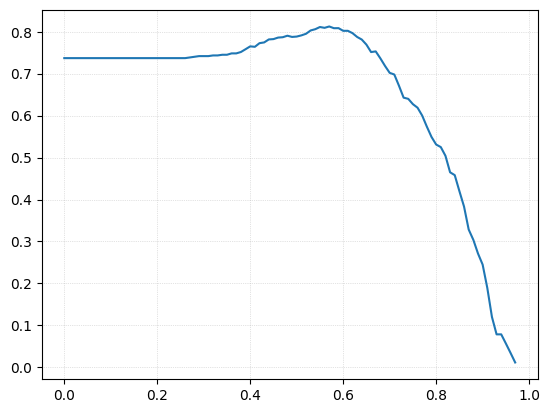

In [32]:
df_f1 = pd.DataFrame(threshold_collection, columns=["threshold", "f1"])

plt.plot(list(threshold_collection.keys()), list(threshold_collection.values()))
plt.grid(True, which='both', linestyle=':', linewidth=0.5, alpha=0.7)

### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.36

In [37]:
df = prepare_data(df_origin)
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=random_state)

columns = categorical_columns + numerical_columns

In [52]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)

In [53]:
scores = []

for i, (train_idx, validation_idx) in enumerate(kf.split(df_full_train)):
    df_train = df_full_train.iloc[train_idx]
    y_train = df_train[target_column].values

    df_validation = df_full_train.iloc[validation_idx]
    y_validation = df_validation[target_column].values

    dict_train, dict_validation = create_dictionaries(df_train, df_validation, columns)
    vectorizer = create_vectorizer_and_learn_categories(dict_train)
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

    X_train = vectorizer.transform(dict_train)
    model.fit(X_train, y_train)

    X_validation = vectorizer.transform(dict_validation)
    y_pred = model.predict_proba(X_validation)[:, 1]

    fpr, tpr, threshold = roc_curve(y_validation, y_pred)
    scores.append(auc(fpr, tpr))

In [48]:
print(f"The standard deviation between values is: {round(np.std(scores), 2)}")

The standard deviation between values is: 0.04


### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [56]:
deviation_scores = {}

for c in [0.000001, 0.001, 1]:
    for i, (train_idx, validation_idx) in enumerate(kf.split(df_full_train)):
        df_train = df_full_train.iloc[train_idx]
        y_train = df_train[target_column].values

        df_validation = df_full_train.iloc[validation_idx]
        y_validation = df_validation[target_column].values

        dict_train, dict_validation = create_dictionaries(df_train, df_validation, columns)
        vectorizer = create_vectorizer_and_learn_categories(dict_train)
        model = LogisticRegression(solver='liblinear', C=c, max_iter=1000)

        X_train = vectorizer.transform(dict_train)
        model.fit(X_train, y_train)

        X_validation = vectorizer.transform(dict_validation)
        y_pred = model.predict_proba(X_validation)[:, 1]

        fpr, tpr, _ = roc_curve(y_validation, y_pred)
        deviation_scores[c] = round(auc(fpr, tpr), 3)

In [57]:
deviation_scores

{1e-06: 0.577, 0.001: 0.9, 1: 0.856}